# Project 1: Cyclic Coordinate Descent for Regularized Logistic Regression


### Analysis functions

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
from LogRegCCD import LogRegCCD
import os

In [20]:
RESULT_DIR = "./results/"
os.makedirs(RESULT_DIR, exist_ok=True)

In [21]:
def evaluate_performance(logRegCCD, X, y): 

    print("Accuracy score: ", logRegCCD.validate(X, y, accuracy_score))
    print("Precision score: ", logRegCCD.validate(X, y, precision_score))
    print("Recall score: ", logRegCCD.validate(X, y, recall_score))
    print("F-measure score: ", logRegCCD.validate(X, y, f1_score))
    print("Balanced Accuracy score: ", logRegCCD.validate(X, y, balanced_accuracy_score))
    print("AUC-ROC score: ", logRegCCD.validate(X, y, roc_auc_score))
    print("AUC-PR: score: ", logRegCCD.validate(X, y, average_precision_score))

In [22]:
def compare_performance(logRegCCD, X_train, y_train, X_test, y_test): 
    lr_sklearn_none = LogisticRegression(
        penalty=None, 
        solver='lbfgs', 
        max_iter=1000,
        random_state=42 # To ensure reproducibility
    )
    lr_sklearn_none = lr_sklearn_none.fit(X_train, y_train)
    y_prob_none = lr_sklearn_none.predict_proba(X_test)[:, 1]
    y_pred_none = (y_prob_none >= 0.5).astype(int)

    lr_sklearn_l1 = LogisticRegression(
        penalty="l1", 
        solver='liblinear', 
        max_iter=1000,
        random_state=42 # To ensure reproducibility
    )
    lr_sklearn_l1 = lr_sklearn_l1.fit(X_train, y_train)
    y_prob_l1 = lr_sklearn_l1.predict_proba(X_test)[:, 1]
    y_pred_l1 = (y_prob_l1 >= 0.5).astype(int)

    coef_df = pd.DataFrame({
        'log_reg_none': [lr_sklearn_none.intercept_[0]] + lr_sklearn_none.coef_[0],
        'log_reg_l1': [lr_sklearn_l1.intercept_[0]] + lr_sklearn_l1.coef_[0],
        'log_reg_ccd': [logRegCCD.beta_zero] + np.array(logRegCCD.beta)
        })

    compare_metrics = [
        accuracy_score, 
        precision_score, 
        recall_score, 
        f1_score, 
        balanced_accuracy_score, 
        roc_auc_score, 
        average_precision_score
        ] 
    
    metric_names = []
    log_reg_ccd_score = []
    log_reg_none_score = []
    log_reg_l1_score = []
    log_reg_ccd_score_train = []
    
    for metric in compare_metrics: 
        metric_names.append(metric.__name__)
        log_reg_ccd_score.append(logRegCCD.validate(X_test, y_test, metric))
        log_reg_ccd_score_train.append(logRegCCD.validate(X_train, y_train, metric))
        log_reg_none_score.append(metric(y_test, y_pred_none))
        log_reg_l1_score.append(metric(y_test, y_pred_l1))
    
    return pd.DataFrame({
        'metric_name': metric_names, 
        'log_reg_ccd_score': log_reg_ccd_score, 
        'log_reg_ccd_score_train': log_reg_ccd_score_train, 
        'log_reg_none_score': log_reg_none_score, 
        'log_reg_l1_score': log_reg_l1_score, 
        }), coef_df

In [ ]:
def analyze_dataset(X, y, filename, split=True): 
    if split: 
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    else: 
        X_train, X_valid, X_test, y_train, y_valid, y_test = X, X, X, y, y, y

    print("X_train shape: ", X_train.shape)
    print("Train set target distribution (P as 1, N as 0):", sum(y_train) / len(y_train))
    print("X_valid shape: ", X_valid.shape)
    print("X_test shape: ", X_test.shape)


    logRegCCD = LogRegCCD()
    logRegCCD = logRegCCD.fit(X_train, y_train, X_valid, y_valid)
    logRegCCD.full_history.to_csv(RESULT_DIR + f"{filename}_iteration_history.csv", index=False)

    logRegCCD.plot_score(RESULT_DIR + f"{filename}_plot_score.png")
    logRegCCD.plot_coeff(RESULT_DIR + f"{filename}_plot_coeff.png")

    comparison, coef_df = compare_performance(logRegCCD, X_train, y_train, X_test, y_test)
    comparison.to_csv(RESULT_DIR + f"{filename}_log_reg_comparison.csv", index=False)
    coef_df.to_csv(RESULT_DIR + f"{filename}_log_reg_coefs.csv", index=False)
    print(logRegCCD.beta_zero)
    print("-----------------")
    print("Comparison with sklearn Logistic Regression: ")
    print(comparison)

    print("-----------------")
    print("Performance for lambda 0: ")
    logRegCCD_0 = LogRegCCD()
    logRegCCD_0 = logRegCCD_0.single_fit(X_train, y_train, lambda_ = 0)
    evaluate_performance(logRegCCD_0, X_valid, y_valid)



    

## Tecator dataset

X_train shape:  (192, 124)
Train set target distribution (P as 1, N as 0): 0.4270833333333333
X_valid shape:  (24, 124)


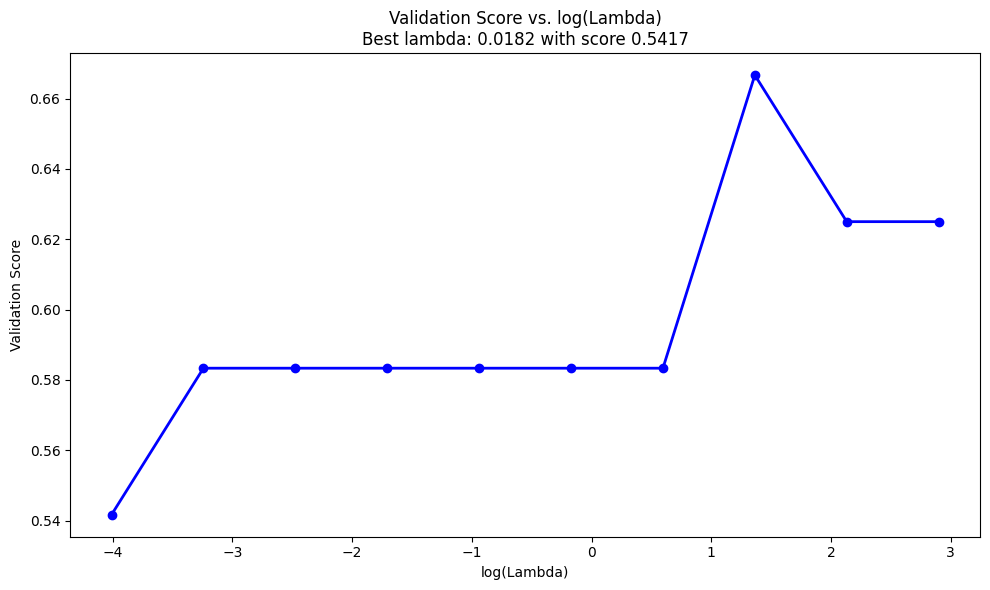

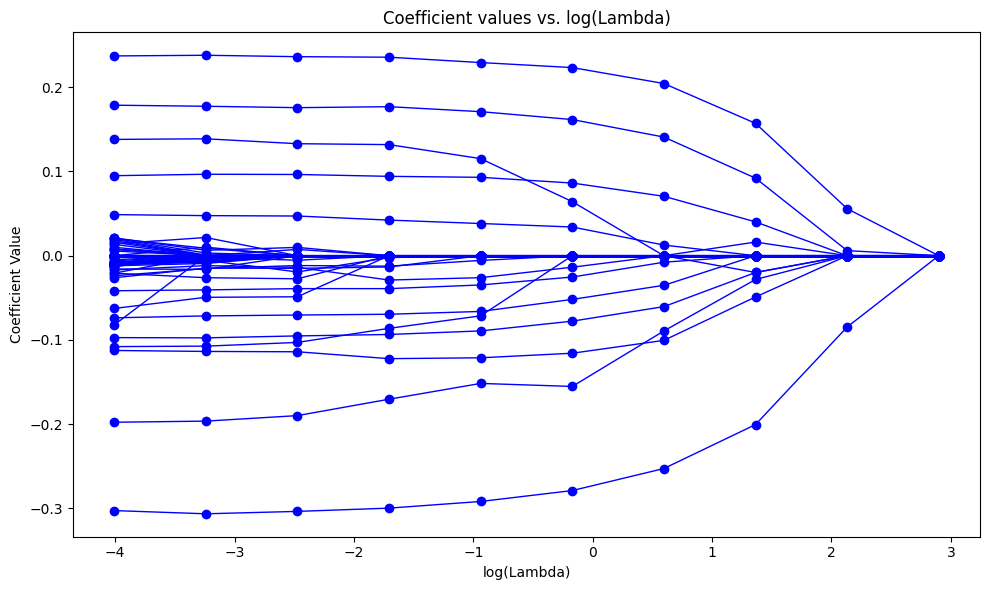

-0.23353887230181786
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.541667                 0.630208   
1          precision_score           0.500000                 0.600000   
2             recall_score           0.363636                 0.402439   
3                 f1_score           0.421053                 0.481752   
4  balanced_accuracy_score           0.527972                 0.601220   
5            roc_auc_score           0.527972                 0.601220   
6  average_precision_score           0.473485                 0.496672   

   log_reg_none_score  log_reg_l1_score  
0            0.916667          0.875000  
1            1.000000          0.900000  
2            0.818182          0.818182  
3            0.900000          0.857143  
4            0.909091          0.870629  
5            0.909091          0.870629  
6            0.901515       

In [27]:
tecator_data = pd.read_csv("data/tecator.csv", header=None)
tecator_X = tecator_data.iloc[:, :-1]
tecator_y = (tecator_data.iloc[:, -1] == 'P').astype(int)
analyze_dataset(tecator_X, tecator_y, "tecator")

X_train shape:  (240, 124)
Train set target distribution (P as 1, N as 0): 0.425
X_valid shape:  (240, 124)


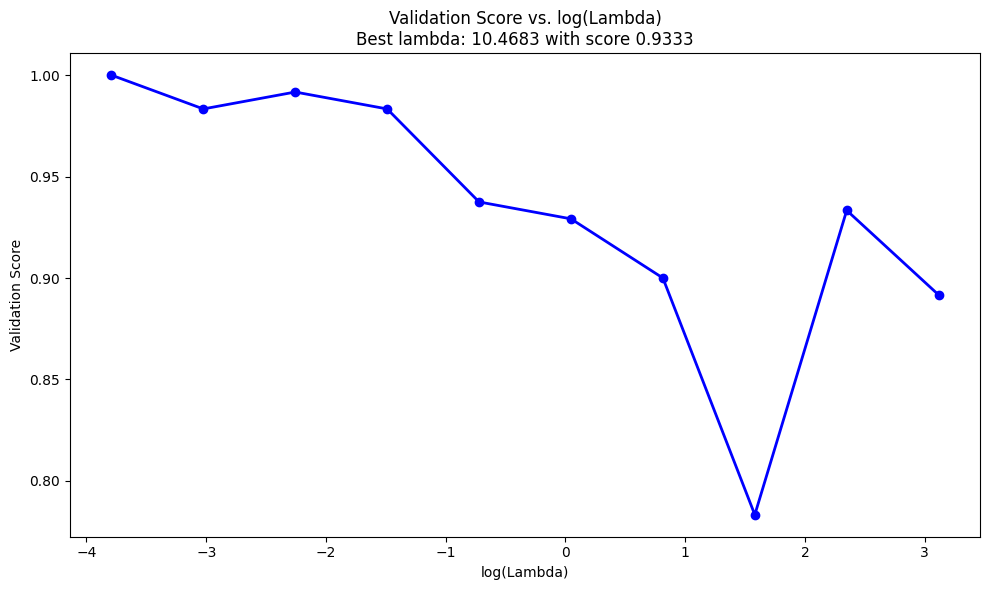

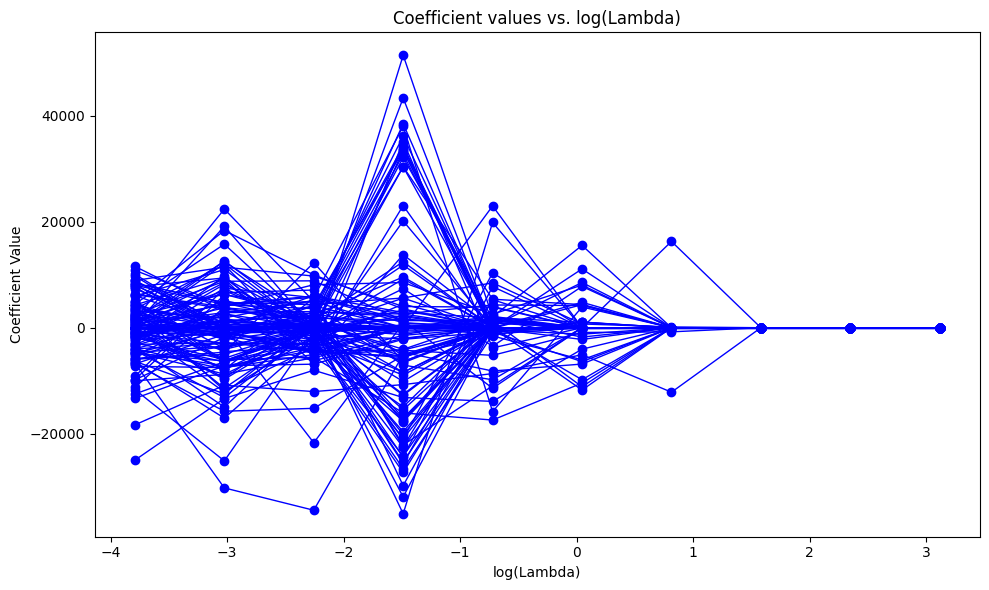

-0.3462896908345021
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.933333                 0.933333   
1          precision_score           0.947917                 0.947917   
2             recall_score           0.892157                 0.892157   
3                 f1_score           0.919192                 0.919192   
4  balanced_accuracy_score           0.927962                 0.927962   
5            roc_auc_score           0.927962                 0.927962   
6  average_precision_score           0.891524                 0.891524   

   log_reg_none_score  log_reg_l1_score  
0                 1.0          0.987500  
1                 1.0          0.980583  
2                 1.0          0.990196  
3                 1.0          0.985366  
4                 1.0          0.987852  
5                 1.0          0.987852  
6                 1.0        

In [28]:
analyze_dataset(tecator_X, tecator_y, "tecator_all_training_data", split=False)

## Sonar dataset

In [ ]:
sonar_data = pd.read_csv("data/sonar.csv", header=None)
sonar_X = sonar_data.iloc[:, :-1]
sonar_y = (sonar_data.iloc[:, -1] == 'Mine').astype(int)

# extended with dummy variables to exceed 50% rule
sonar_X_dummy = sonar_X.copy()
for col in sonar_X_dummy.columns:
    sonar_X_dummy[col] = np.random.permutation(sonar_X_dummy[col])
sonar_X = pd.concat([sonar_X, sonar_X_dummy], axis=1)
analyze_dataset(sonar_X, sonar_y, "sonar")

X_train shape:  (166, 120)
Train set target distribution (P as 1, N as 0): 0.5120481927710844
X_valid shape:  (21, 120)


In [ ]:
analyze_dataset(sonar_X, sonar_y, "sonar_all_training_data", split=False)

## Isolet dataset

In [24]:
isolet_data = pd.read_csv("data/isolet.csv", header=None)
isolet_X = isolet_data.iloc[:, :-1]
isolet_y = (isolet_data.iloc[:, -1] == 2).astype(int)
analyze_dataset(sonar_X, sonar_y, "isolet")

FileNotFoundError: [Errno 2] No such file or directory: 'data/isolet.csv'

## ...

## Synthetic dataset

In [ ]:
def generate_synthetic_data(p, n, d, g, seed=42):
    """
    Generate a synthetic dataset based on the given parameters.
    
    Parameters
    ----------
        p: float
            Prior probability for class Y=1.
        n: int
            Number of observations.
        d:  int
            Dimensionality of feature space.
        g: float 
            Covariance decay factor.
    
    Returns
    ----------
        DataFrame: A DataFrame containing generated features and class labels.
    """
    np.random.seed(seed)
    # Generate binry class variable
    y = np.random.binomial(1, p, size=n)

    # Define means for multivariate normal distribution
    mean_0 = np.zeros(d)
    mean_1 = np.array([1 / (i + 1) for i in range(d)])

    # Define covariance matrix S
    indices = np.arange(d)
    S = np.array([[g ** np.abs(i - j) for j in indices] for i in indices])
    
    # Create DataFrame
    X = np.array([
        np.random.multivariate_normal(mean_1 if y_id == 1 else mean_0, S)
        for y_id in y
    ])
    columns = [f'X{i+1}' for i in range(d)]
    X = pd.DataFrame(X, columns=columns)
    
    return X, y


### d = 2

In [ ]:
np.random.seed(42)
p = 0.5
n = 300
d = 2
g = 0.95

synthetic_X, synthetic_y = generate_synthetic_data(p, n, d, g)
plt.scatter(synthetic_X["X1"], synthetic_X["X2"], c=synthetic_y)
plt.show()

In [ ]:
synthetic_X_train, synthetic_X_valid, synthetic_y_train, synthetic_y_valid = train_test_split(
    synthetic_X, synthetic_y, test_size=0.2, random_state=42, stratify=synthetic_y
)

logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(synthetic_X_train, synthetic_y_train, synthetic_X_valid, synthetic_y_valid)
# Get predicted probabilities
y_prob_syn = logRegCCD.predict_proba(synthetic_X_valid)

evaluate_performance(logRegCCD, synthetic_X_valid, synthetic_y_valid)

y_pred_syn = (y_prob_syn >= 0.5).astype(int)
plt.scatter(synthetic_X_valid.iloc[:,0], synthetic_X_valid.iloc[:,1], c=y_pred_syn)
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42, penalty='none').fit(synthetic_X_train, synthetic_y_train)
print("Accuracy: ", clf.score(synthetic_X_valid, synthetic_y_valid))

print("Beta: ", clf.coef_)
print("Beta zero: ", clf.intercept_)
y_pred_lg = clf.predict(synthetic_X_valid)
plt.scatter(synthetic_X_valid.iloc[:,0], synthetic_X_valid.iloc[:,1], c=y_pred_lg)
plt.show()

In [ ]:
logRegCCD.plot_score()
logRegCCD.plot_coeff()

## predict_students_dropout_and_academic_success

In [ ]:
student_dropout_X = pd.read_csv("./data/predict_students_dropout_and_academic_success/data.csv", sep=";")
student_dropout_y = (student_dropout_X['Target'] == 'Graduate').astype(int)
student_dropout_X.drop("Target", inplace=True, axis=1)
print(student_dropout_X.shape)
print("Graduated: ", sum(student_dropout_y)/len(student_dropout_y))
student_dropout_X.head()

In [ ]:
student_dropout_X_train, student_dropout_X_valid, student_dropout_y_train, student_dropout_y_valid = train_test_split(
    student_dropout_X, student_dropout_y, test_size=0.2, random_state=42, stratify=student_dropout_y
)


logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(student_dropout_X_train, student_dropout_y_train, student_dropout_X_valid, student_dropout_y_valid)

evaluate_performance(logRegCCD, student_dropout_X_valid, student_dropout_y_valid)

In [ ]:
logRegCCD.plot_score()

In [ ]:
logRegCCD.plot_coeff()

In [ ]:
clf = LogisticRegression(random_state=42, penalty='none').fit(student_dropout_X_train, student_dropout_y_train)
print("Accuracy: ", clf.score(student_dropout_X_valid, student_dropout_y_valid))

print("Beta: ", clf.coef_)
print("Beta zero: ", clf.intercept_)